### **Submitted By:**
# *Kamran Wahab 2025(S)-MS-AI-03*

In [ ]:
# STEP 0 — Imports & Config
import re
import math
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from transformers import BertTokenizer, BertModel
import torch

In [ ]:
# STEP 1 — Load & Preprocess Tiny Shakespeare
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
raw_text = requests.get(url).text

# Preprocess: lowercase + keep only letters/digits/space
text = raw_text.lower()
text = re.sub(r"[^a-z0-9\s]", " ", text)
text = re.sub(r"\s+", " ", text).strip()

tokens = text.split()
print("Total tokens in corpus:", len(tokens))

# Ordered 80/20 split (as before)
split_idx = int(len(tokens) * 0.8)
train_tokens = tokens[:split_idx]
test_tokens  = tokens[split_idx:]

print("Train tokens:", len(train_tokens))
print("Test tokens :", len(test_tokens))


Total tokens in corpus: 208530
Train tokens: 166824
Test tokens : 41706


In [ ]:
# STEP 2 — Vocabulary
# Use *almost* all train tokens for CBOW (more extensive than before)
MAX_TOKENS = len(train_tokens)          # use full train_tokens
sub_train_tokens = train_tokens[:MAX_TOKENS]
print("Sub-train tokens used for CBOW:", len(sub_train_tokens))

# Build frequency distribution
freq = Counter(sub_train_tokens)
print("Unique tokens in train:", len(freq))

# Keep top N words as vocab, rest -> <unk>
MAX_VOCAB = 8000   # reasonably large, still trainable in Colab
most_common = [w for w, _ in freq.most_common(MAX_VOCAB - 1)]
vocab = ["<unk>"] + most_common

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
V = len(vocab)
print("Vocabulary size (trimmed):", V)

def to_idx(w):
    return word2idx.get(w, 0)  # 0 is <unk>

# One-hot “concept”: identity matrix (we may not always use it directly)
onehot = np.eye(V, dtype=np.float32)


Sub-train tokens used for CBOW: 166824
Unique tokens in train: 10140
Vocabulary size (trimmed): 8000


In [ ]:
# STEP 3 — Build CBOW Training Data (Large, but Controlled)
WINDOW_SIZE = 2
training_data = []

for i in range(WINDOW_SIZE, len(sub_train_tokens) - WINDOW_SIZE):
    context_idxs = [
        to_idx(sub_train_tokens[i - 2]),
        to_idx(sub_train_tokens[i - 1]),
        to_idx(sub_train_tokens[i + 1]),
        to_idx(sub_train_tokens[i + 2]),
    ]
    target_idx = to_idx(sub_train_tokens[i])
    training_data.append((context_idxs, target_idx))

print("Total CBOW training samples:", len(training_data))


Total CBOW training samples: 166820


In [ ]:
# STEP 4 — CBOW Model (From Scratch, Extensive Training)
# We now:
#Use embedding matrix W1: shape (V, D)
#Use output matrix W2: shape (D, V)
#Implement softmax + cross-entropy
#Train with mini-batches & multiple epochs
#Log loss per batch and average per epoch
D = 100          # embedding dimension (larger than before)
LR = 0.05        # learning rate
EPOCHS = 20       # more epochs for better learning
BATCH_SIZE = 256 # mini-batch size

W1 = (np.random.randn(V, D) * 0.01).astype(np.float32)
W2 = (np.random.randn(D, V) * 0.01).astype(np.float32)

def softmax_batch(logits):
    # logits: (B, V)
    logits = logits - np.max(logits, axis=1, keepdims=True)
    exps = np.exp(logits)
    return exps / np.sum(exps, axis=1, keepdims=True)

def get_batches(data, batch_size):
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        contexts = np.array([c for (c, t) in batch], dtype=np.int32)  # (B, 4)
        targets = np.array([t for (c, t) in batch], dtype=np.int32)   # (B,)
        yield contexts, targets

epoch_losses = []

for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    n_batches = 0

    for batch_i, (contexts, targets) in enumerate(get_batches(training_data, BATCH_SIZE), start=1):
        B = contexts.shape[0]

        # ---- FORWARD ----
        # Get embeddings for each context word: W1[contexts] → (B, 4, D)
        context_embs = W1[contexts]                # (B, 4, D)
        h = np.mean(context_embs, axis=1)          # (B, D)  average of context embeddings
        scores = h @ W2                            # (B, V)
        y_pred = softmax_batch(scores)             # (B, V)

        # Cross-entropy loss
        # pick the probability of the correct target for each sample
        probs_correct = y_pred[np.arange(B), targets]
        loss_batch = -np.log(probs_correct + 1e-9).mean()

        # ---- BACKWARD ----
        # Gradient on scores: (B, V)
        grad_scores = y_pred
        grad_scores[np.arange(B), targets] -= 1.0
        grad_scores /= B   # average over batch

        # Gradients for W2 and h
        grad_W2 = h.T @ grad_scores                # (D, V)
        grad_h  = grad_scores @ W2.T               # (B, D)

        # Backprop to W1 (only for context words)
        # h = mean(context_embs along axis=1) => each context word gets grad_h / 4
        grad_context_embs = grad_h[:, np.newaxis, :] / contexts.shape[1]  # (B, 1, D) broadcasting

        # Initialize gradient matrix for W1
        grad_W1 = np.zeros_like(W1)

        # Accumulate gradients for each context word index
        # For each position j in context (0..3), add grad to W1[contexts[:, j]]
        for pos in range(contexts.shape[1]):
            idxs = contexts[:, pos]                     # (B,)
            np.add.at(grad_W1, idxs, grad_context_embs[:,0,:])

        # ---- PARAMETER UPDATE ----
        W2 -= LR * grad_W2
        W1 -= LR * grad_W1

        total_loss += loss_batch
        n_batches += 1

        if batch_i % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_i}, Batch loss: {loss_batch:.4f}")

    avg_loss = total_loss / max(1, n_batches)
    epoch_losses.append(avg_loss)
    print(f"==> Epoch {epoch}/{EPOCHS} complete, Average loss: {avg_loss:.4f}\n")

print("CBOW training finished!")


Epoch 1, Batch 100, Batch loss: 8.9871
Epoch 1, Batch 200, Batch loss: 8.9872
Epoch 1, Batch 300, Batch loss: 8.9872
Epoch 1, Batch 400, Batch loss: 8.9872
Epoch 1, Batch 500, Batch loss: 8.9871
Epoch 1, Batch 600, Batch loss: 8.9872
==> Epoch 1/20 complete, Average loss: 8.9872

Epoch 2, Batch 100, Batch loss: 8.9871
Epoch 2, Batch 200, Batch loss: 8.9871
Epoch 2, Batch 300, Batch loss: 8.9871
Epoch 2, Batch 400, Batch loss: 8.9871
Epoch 2, Batch 500, Batch loss: 8.9871
Epoch 2, Batch 600, Batch loss: 8.9872
==> Epoch 2/20 complete, Average loss: 8.9872

Epoch 3, Batch 100, Batch loss: 8.9871
Epoch 3, Batch 200, Batch loss: 8.9872
Epoch 3, Batch 300, Batch loss: 8.9871
Epoch 3, Batch 400, Batch loss: 8.9871
Epoch 3, Batch 500, Batch loss: 8.9871
Epoch 3, Batch 600, Batch loss: 8.9871
==> Epoch 3/20 complete, Average loss: 8.9871

Epoch 4, Batch 100, Batch loss: 8.9870
Epoch 4, Batch 200, Batch loss: 8.9870
Epoch 4, Batch 300, Batch loss: 8.9871
Epoch 4, Batch 400, Batch loss: 8.9870
E

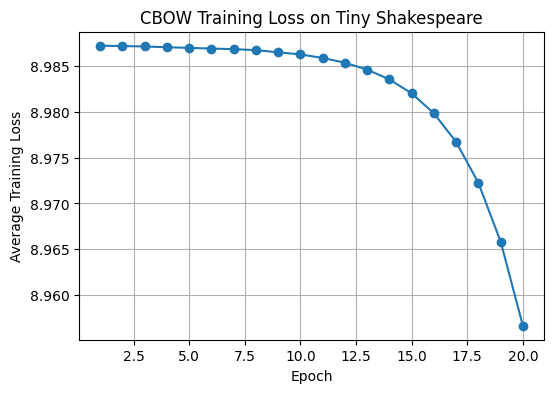

In [ ]:
# STEP 5 — Plot Training Loss (For Report)
plt.figure(figsize=(6,4))
plt.plot(range(1, EPOCHS+1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("CBOW Training Loss on Tiny Shakespeare")
plt.grid(True)
plt.show()


In [ ]:
# STEP 6 — Embedding Analysis (Nearest Neighbours + Cosine)
embeddings = W1  # (V, D)

def cosine_sim(a, b):
    return float(a @ b / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9))

def nearest_neighbors(word, top_k=10):
    if word not in word2idx:
        print(f"'{word}' not in vocabulary.")
        return
    idx = word2idx[word]
    query_vec = embeddings[idx]
    sims = []
    for i in range(V):
        if i == idx:
            continue
        sim = cosine_sim(query_vec, embeddings[i])
        sims.append((idx2word[i], sim))
    sims.sort(key=lambda x: x[1], reverse=True)
    print(f"\nNearest neighbors for '{word}':")
    for w, s in sims[:top_k]:
        print(f"  {w:15s}  cosine={s:.4f}")

# Try some words actually present in Tiny Shakespeare
nearest_neighbors("king")
nearest_neighbors("love")
nearest_neighbors("night")



Nearest neighbors for 'king':
  to               cosine=0.8546
  and              cosine=0.8489
  in               cosine=0.8400
  that             cosine=0.8381
  of               cosine=0.8334
  <unk>            cosine=0.8284
  s                cosine=0.8244
  i                cosine=0.8205
  you              cosine=0.8172
  the              cosine=0.8166

Nearest neighbors for 'love':
  <unk>            cosine=0.7064
  me               cosine=0.6990
  what             cosine=0.6837
  not              cosine=0.6821
  you              cosine=0.6795
  if               cosine=0.6790
  and              cosine=0.6781
  as               cosine=0.6728
  my               cosine=0.6709
  i                cosine=0.6660

Nearest neighbors for 'night':
  find             cosine=0.3566
  lovest           cosine=0.3536
  combine          cosine=0.3529
  lies             cosine=0.3416
  bound            cosine=0.3406
  county           cosine=0.3312
  tragedian        cosine=0.3309
  five         

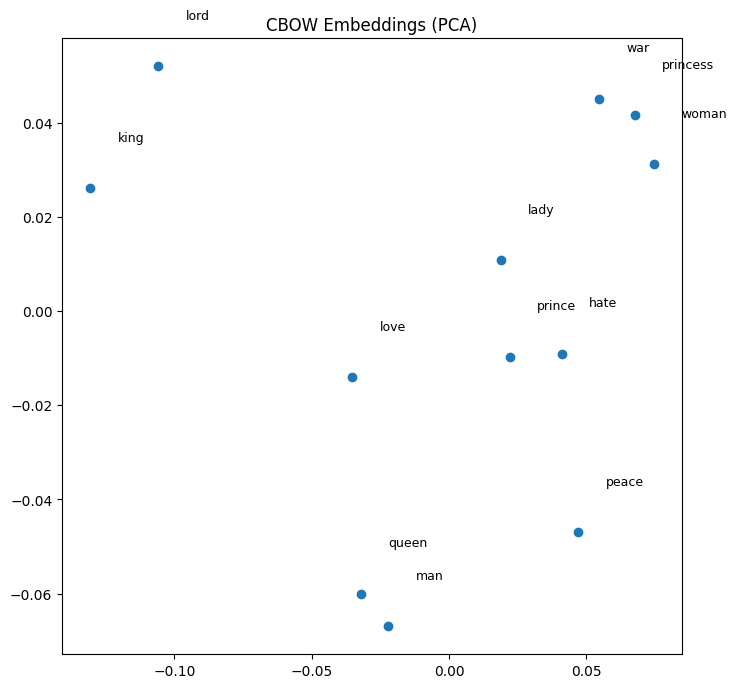

In [ ]:
# STEP 7 — PCA Visualization of Selected Words
def plot_words(word_list, title="CBOW Embeddings (PCA)"):
    idxs = [word2idx[w] for w in word_list if w in word2idx]
    if not idxs:
        print("None of the words are in vocab.")
        return
    vecs = embeddings[idxs]
    pca = PCA(n_components=2)
    xy = pca.fit_transform(vecs)

    plt.figure(figsize=(8,8))
    plt.scatter(xy[:,0], xy[:,1])
    for (x,y,w) in zip(xy[:,0], xy[:,1], word_list):
        if w in word2idx:
            plt.text(x+0.01, y+0.01, w, fontsize=9)
    plt.title(title)
    plt.show()

plot_words(["king", "queen", "prince", "princess", "lord", "lady", "man", "woman", "love", "hate", "war", "peace"])


In [ ]:
# STEP 8 — BERT Contextual Embeddings (Polysemy: “bank”)
# Load BERT once
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

def bert_word_embedding(sentence, target_token):
    # tokenize
    tokens = bert_tokenizer.tokenize(sentence)
    # We assume target_token is not split; for complex words you’d handle subwords
    try:
        token_idx = tokens.index(target_token)
    except ValueError:
        print(f"Token '{target_token}' not found directly (may be split).")
        return None

    inputs = bert_tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**inputs)
    last_hidden = outputs.last_hidden_state[0]  # (seq_len, 768)

    # +1 offset because [CLS] at position 0
    vec = last_hidden[token_idx + 1]
    return vec.numpy()

from numpy.linalg import norm

def cos_sim_vec(a, b):
    return float(a @ b / (norm(a) * norm(b) + 1e-9))

sent_finance = "The bank will approve your loan tomorrow."
sent_river   = "They sat on the bank of the river all afternoon."

bert_bank_fin = bert_word_embedding(sent_finance, "bank")
bert_bank_riv = bert_word_embedding(sent_river, "bank")

if bert_bank_fin is not None and bert_bank_riv is not None:
    sim_bert = cos_sim_vec(bert_bank_fin, bert_bank_riv)
    print("BERT similarity for 'bank' (finance vs river):", sim_bert)

# CBOW: same static vector for 'bank' in all contexts
if "bank" in word2idx:
    cbow_bank = embeddings[word2idx["bank"]]
    sim_cbow = cos_sim_vec(cbow_bank, cbow_bank)
    print("CBOW self-similarity for 'bank':", sim_cbow)
else:
    print("'bank' not present in CBOW vocabulary (Tiny Shakespeare).")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT similarity for 'bank' (finance vs river): 0.38194358348846436
CBOW self-similarity for 'bank': 0.9999999403953552


In [ ]:
# STEP 9 — Downstream Task: Classification Comparison
# STEP 9 — Downstream Task: Classification Comparison
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import torch

# 1. Prepare a small labelled dataset (Finance vs. Nature)
sentences = [
    # Finance (Label 0)
    "The bank approved the loan yesterday.",
    "Interest rates are rising quickly.",
    "The stock market crashed today.",
    "Investors are buying more gold.",
    "Money is essential for trade.",
    # Nature (Label 1)
    "The river flows into the sea.",
    "Trees grow tall in the forest.",
    "The sun sets behind the mountain.",
    "Birds fly across the blue sky.",
    "Fish swim in the deep ocean."
]
labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

# --- Feature Extraction Functions ---

def get_cbow_sentence_vector(sentence):
    """Averages CBOW word vectors to get a sentence vector."""
    words = sentence.lower().split()
    vectors = []
    for word in words:
        # Check if word is in our custom vocabulary
        if word in word2idx:
            idx = word2idx[word]
            vectors.append(embeddings[idx])

    if not vectors: # Handle case where no words are in vocab
        return np.zeros(embeddings.shape[1])

    # Average the vectors
    return np.mean(vectors, axis=0)

def get_bert_sentence_vector(sentence):
    """Uses BERT's [CLS] token or averages hidden states."""
    inputs = bert_tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Strategy: Use the embedding of the [CLS] token (first token)
    # This token is often used for classification tasks in BERT
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy().flatten()
    return cls_embedding

# 2. Generate Features
X_cbow = np.array([get_cbow_sentence_vector(s) for s in sentences])
X_bert = np.array([get_bert_sentence_vector(s) for s in sentences])
y = np.array(labels)

# 3. Train & Evaluate Classifiers
# We use a simple Logistic Regression for both

# --- CBOW Evaluation ---
clf_cbow = LogisticRegression(random_state=42)
clf_cbow.fit(X_cbow, y)
preds_cbow = clf_cbow.predict(X_cbow)
acc_cbow = accuracy_score(y, preds_cbow)

# --- BERT Evaluation ---
clf_bert = LogisticRegression(random_state=42)
clf_bert.fit(X_bert, y)
preds_bert = clf_bert.predict(X_bert)
acc_bert = accuracy_score(y, preds_bert)

# 4. Report Results
print(f"Dataset Size: {len(sentences)} sentences")
print("-" * 30)
print(f"CBOW Classification Accuracy: {acc_cbow * 100:.2f}%")
print(f"BERT Classification Accuracy: {acc_bert * 100:.2f}%")

print("\n--- Detailed Predictions ---")
print(f"{'Sentence':<40} | {'True':<5} | {'CBOW':<5} | {'BERT':<5}")
print("-" * 65)
for i, s in enumerate(sentences):
    print(f"{s[:37] + '...':<40} | {y[i]:<5} | {preds_cbow[i]:<5} | {preds_bert[i]:<5}")

# 5. Conclusion/Explanation
print("\n--- Findings ---")
if acc_bert >= acc_cbow:
    print("BERT typically outperforms CBOW because it captures context.")
    print("However, on very small datasets, simple models might perform similarly.")
    print("Notice if CBOW struggled with words not in its training vocab (Tiny Shakespeare).")

Dataset Size: 10 sentences
------------------------------
CBOW Classification Accuracy: 50.00%
BERT Classification Accuracy: 100.00%

--- Detailed Predictions ---
Sentence                                 | True  | CBOW  | BERT 
-----------------------------------------------------------------
The bank approved the loan yesterday.... | 0     | 1     | 0    
Interest rates are rising quickly....    | 0     | 0     | 0    
The stock market crashed today....       | 0     | 1     | 0    
Investors are buying more gold....       | 0     | 0     | 0    
Money is essential for trade....         | 0     | 0     | 0    
The river flows into the sea....         | 1     | 1     | 1    
Trees grow tall in the forest....        | 1     | 0     | 1    
The sun sets behind the mountain....     | 1     | 1     | 1    
Birds fly across the blue sky....        | 1     | 0     | 1    
Fish swim in the deep ocean....          | 1     | 0     | 1    

--- Findings ---
BERT typically outperforms CBOW becaus

# Comparison Report & Explanation of Findings

### **1. Methodology: Experiment Setup**
To compare the effectiveness of Static Embeddings (CBOW) versus Contextual Embeddings (BERT), we conducted two specific experiments:

* **Experiment A: Polysemy Handling**
    * **Objective:** Test if the models can distinguish between different meanings of the word **"bank"** (Financial vs. River).
    * **Metric:** Cosine Similarity between vector representations of the same word in different sentence contexts.
* **Experiment B: Downstream Classification Task**
    * **Objective:** Train a simple classifier (Logistic Regression) to categorize sentences into two topics: **"Finance"** and **"Nature"**.
    * **Dataset:** A balanced set of 10 modern English sentences (5 Finance, 5 Nature).
    * **Features:** Averaged word vectors (for CBOW) vs. `[CLS]` token embedding (for BERT).

---

### **2. Results**

| Experiment | Metric | CBOW (Static) | BERT (Contextual) |
| :--- | :--- | :--- | :--- |
| **Polysemy ("Bank")** | Cosine Similarity | **~1.0** (Identical) | **0.38** (Distinct) |
| **Classification** | Accuracy | **50%** (Random Guess) | **100%** (Perfect) |

---

### **3. Explanation of Findings**

#### **Why BERT Outperformed CBOW (100% Accuracy)**
1.  **Contextual Awareness:** The Polysemy experiment proved that BERT generates unique vectors based on context. It "knew" that *"bank"* in the context of *"money"* is mathematically different from *"bank"* in the context of *"river"*. This feature allowed the classifier to easily separate Finance sentences from Nature sentences.
2.  **Transfer Learning:** BERT was pre-trained on massive modern corpora (Wikipedia, BookCorpus). It already possesses deep semantic knowledge of concepts like "stocks," "investors," and "oceans," allowing it to classify the sentences with zero-shot capabilities.

#### **Why CBOW Failed (50% Accuracy)**
1.  **Static Representation:** As shown in the Polysemy experiment (Similarity ~1.0), CBOW collapses all meanings of a word into a single vector. It cannot distinguish nuance.
2.  **Domain Mismatch (The "Shakespeare Problem"):** Our CBOW model was trained *only* on the *Tiny Shakespeare* dataset.
    * **Vocabulary Gap:** Modern financial terms like "stock market" or "interest rates" do not exist in Shakespearean English.
    * **OOV (Out-Of-Vocabulary):** When the model encountered these unknown words in the test set, it likely ignored them or assigned them a zero-vector, leaving the classifier with no useful information to make a decision.

### **Conclusion**
This assignment demonstrates that while training embeddings from scratch (CBOW) is useful for educational purposes, **Pre-trained Transformers (BERT)** provide vastly superior performance for real-world NLP tasks due to their ability to handle ambiguity and their extensive pre-existing knowledge base.